<a href="https://colab.research.google.com/github/zzeeddd95/capstone-project/blob/master/LSTMgoog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is a recurrent neural network, specifically an LSTM network designed to predict google stock prices one day in advance. **

In [ ]:
#import libraries

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [ ]:
#Get goog stock
googstock = web.DataReader('GOOG', data_source='yahoo', start='2010-05-27', end='2020-05-27')
googstock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-05-27,245.235794,239.626816,241.569534,244.314255,5639200.0,244.314255
2010-05-28,245.803665,240.598175,245.449997,241.908264,5811200.0,241.908264
2010-06-01,244.613129,239.163559,239.317978,240.284363,5353500.0,240.284363
2010-06-02,246.012878,239.831055,242.431305,245.763824,5100500.0,245.763824
2010-06-03,253.051498,246.426331,246.630569,251.855988,7328700.0,251.855988
...,...,...,...,...,...,...
2020-05-20,1410.420044,1387.250000,1389.579956,1406.719971,1655400.0,1406.719971
2020-05-21,1415.489990,1393.449951,1408.000000,1402.800049,1385000.0,1402.800049
2020-05-22,1412.760010,1391.829956,1396.709961,1410.420044,1309400.0,1410.420044


In [ ]:
#Get dataset information
googstock.shape

(2517, 6)

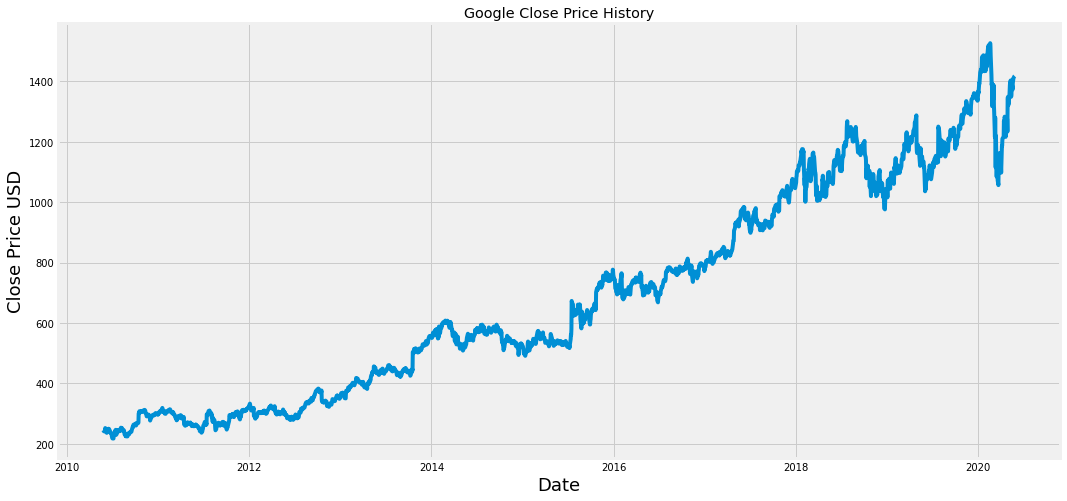

In [ ]:
#visualize closing goog price
plt.figure(figsize=(16,8))
plt.title('Google Close Price History')
plt.plot(googstock['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.show()

**In this next line of code, we will extract the google closing price from the stock dataframe, convert it to a numpy array and create a training dataframe consisiting of 80% of closing stock prices.**

In [ ]:
#extract closing price and position into new datafram
googclose =googstock.filter(['Close'])
#convert dataframe to numpy array
googdata = googclose.values
#obtain row number to train model
training_goog_data = math.ceil(len(googdata)*.8)
training_goog_data

2014

**Normalizing the data is key to ensuring that the neural network works properly, and so a scale of 0,1 is set, and the following code will enable the normalization of the closing price data. this data will then be inserted into is own variable. **

In [ ]:
#scaling data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_goog_data = scaler.fit_transform(googdata)
scaled_goog_data

array([[0.0206904 ],
       [0.01885302],
       [0.0176129 ],
       ...,
       [0.91120837],
       [0.91624856],
       [0.91687473]])

**In the following lines of code, we will be creating the scaled training data to feed into the neural network from the previous 80% variable that was created. the training data will be from row 0 until the final row, and will include all columns. A loop is created in which the x train set will contain data from positions 0-364 on the first pass, and the y train set will contain data from position 365. the value in position 365 is the value that we require our model to predict. the if loop allows for positions to be filled into the x and y variables with respect to iterations. **

In [ ]:
#create the scaled training dataset

train_goog_data = scaled_goog_data[0:training_goog_data,:]
#split the data omtp x_train and y_train datasets

x_train_goog = []
y_train_goog = []

for i in range(365,len(train_goog_data)):
  x_train_goog.append(train_goog_data[i-365:i,0])
  y_train_goog.append(train_goog_data[i,0])
  if i<= 365:
    print(x_train_goog)
    print(y_train_goog)
    print()

[array([0.0206904 , 0.01885302, 0.0176129 , 0.02179739, 0.02644979,
       0.02383258, 0.01881118, 0.01852968, 0.01443648, 0.01937799,
       0.0199448 , 0.01792483, 0.02355487, 0.02480261, 0.02434993,
       0.0243309 , 0.01996762, 0.01908889, 0.01749117, 0.01484733,
       0.01392674, 0.0136985 , 0.00691962, 0.00337802, 0.001301  ,
       0.00018259, 0.        , 0.00537516, 0.00779456, 0.01195242,
       0.01512503, 0.02021108, 0.02102516, 0.02204465, 0.00895481,
       0.01145409, 0.01731618, 0.01576031, 0.0185411 , 0.02053823,
       0.0201236 , 0.02151589, 0.01836611, 0.01860957, 0.01855631,
       0.02067137, 0.02045074, 0.02672367, 0.02740081, 0.02440318,
       0.02635468, 0.02573081, 0.02117732, 0.02128003, 0.01912692,
       0.01883781, 0.02071322, 0.0175292 , 0.01213501, 0.00987159,
       0.01065142, 0.00582785, 0.00705657, 0.00567188, 0.00865808,
       0.00632238, 0.00530669, 0.0092287 , 0.01031287, 0.01302137,
       0.01077696, 0.01312788, 0.01525817, 0.01524295, 0.0175

**The following two cells of code will allow for increased pre processing of the above created variables to allow for training of the model. it is important to reshape the x train data set becase the lstm networks expects the input to be three dimensional (# of samples, # of timesteps, #of features), however the train data set in its current form is two dimensional. **

In [ ]:
#convert the x_train_goog and y_train_goog to numpy array in order to allow the training of lstm model
x_train_goog,y_train_goog=np.array(x_train_goog), np.array(y_train_goog)

In [ ]:
#Reshape the data in order to obtain three dimensional data to feed into LSTM
x_train_goog=np.reshape(x_train_goog,(x_train_goog.shape[0],x_train_goog.shape[1],1))
x_train_goog.shape

(1649, 365, 1)

**The following cell includes the LSTM model build, and here is where the neural network hyperparamaters can be tuned to achieve the specific output required. The error for the model is tested using the RMSE. This particular model contains 2 LSTM layers with 200 neurons each, 2 dense layers (allowing for output of predictions from the neuron layers), a model compiler and a model fitter. **

In [10]:
#Build the LSTM model for goog
model = Sequential()
model.add(LSTM(200,return_sequences=True, input_shape=(x_train_goog.shape[1],1)))
model.add(LSTM(200, return_sequences=False))
model.add(Dense(100))
model.add(Dense(1))
#compile the goog model
model.compile(optimizer='adam',loss='mean_squared_error')
#train the model
model.fit(x_train_goog,y_train_goog, batch_size=2,epochs=7)

Epoch 1/7
1649/1649 [==============================] - 734s 445ms/step - loss: 9.1929e-04
Epoch 2/7
1649/1649 [==============================] - 734s 445ms/step - loss: 4.3522e-04
Epoch 3/7
1649/1649 [==============================] - 728s 442ms/step - loss: 2.3795e-04
Epoch 4/7
1649/1649 [==============================] - 725s 440ms/step - loss: 2.6042e-04
Epoch 5/7
1649/1649 [==============================] - 735s 446ms/step - loss: 1.8087e-04
Epoch 6/7
1649/1649 [==============================] - 731s 444ms/step - loss: 1.5773e-04
Epoch 7/7
1649/1649 [==============================] - 717s 435ms/step - loss: 1.7751e-04


In [19]:
#create the testing data set by creating a new array containg scaled values from index 1924 - 2517
test_goog_data = scaled_goog_data[training_goog_data - 365: , :]
#create the datasets x_goog_test and y_goog_test
x_goog_test = []
y_goog_test = googdata[training_goog_data:, :]
for i in range(365,len(test_goog_data)):
  x_goog_test.append(test_goog_data[i-365:i, 0])

In [20]:
#convert data into numpy array
x_goog_test=np.array(x_goog_test)

In [21]:
#Reshape test data
x_goog_test = np.reshape(x_goog_test,(x_goog_test.shape[0],x_goog_test.shape[1],1))

In [22]:
#obtain model predicted price values, we want prediction to obtain same values as y_amzn_test dataset
googpredictions = model.predict(x_goog_test)
googpredictions=scaler.inverse_transform(googpredictions)

In [23]:
#Evaluate the model by getting the RMSE
rmse = np.sqrt( np.mean( googpredictions-y_goog_test)**2)
rmse

6.814657586706325

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


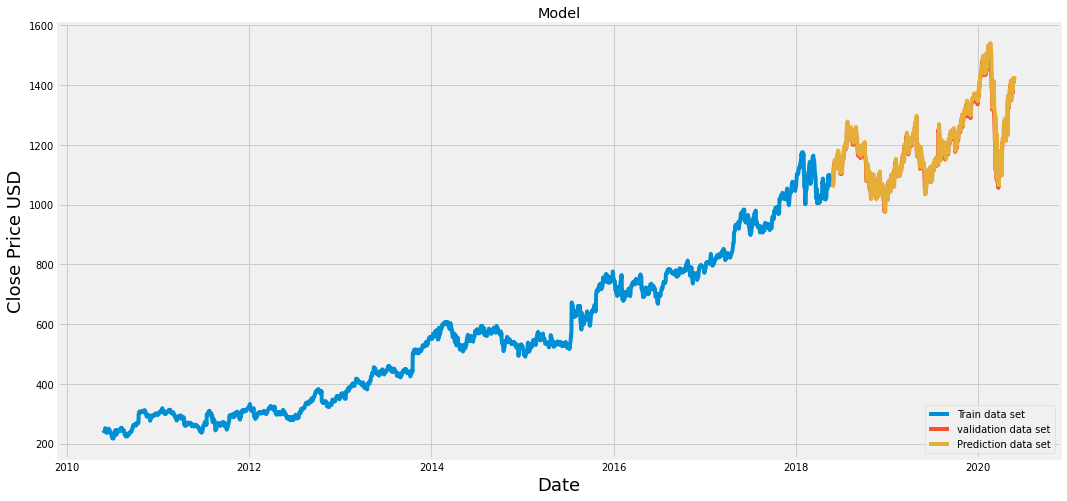

In [24]:
#Plot data
train = googclose[:training_goog_data]
valid = googclose[training_goog_data:]
valid['Predictions'] = googpredictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train data set', 'validation data set','Prediction data set'],loc ='lower right' )
plt.show()

In [25]:
#show the validation price and predicted price
valid

,Close,Predictions
Date,,
2018-05-29,1060.319946,1079.793701
2018-05-30,1067.800049,1062.587280
2018-05-31,1084.989990,1071.149658
2018-06-01,1119.500000,1090.891235
2018-06-04,1139.290039,1129.332642
...,...,...
2020-05-20,1406.719971,1385.223511
2020-05-21,1402.800049,1423.136475
2020-05-22,1410.420044,1416.810913


In [31]:
#Predict future price
goog_quote = web.DataReader('GOOG', data_source='yahoo', start='2010-05-27', end='2020-06-25')
#Create new dataframe
new_df = goog_quote.filter(['Close'])
#Extract last 365 days closing price and convert df to array
last_365_days = new_df[-365:].values
#scalre the data to be valued between 0 and 1
last_365_days_scaled = scaler.transform(last_365_days)
#create an empty list
X_test = []
#Append past 365 days to empty list
X_test.append(last_365_days_scaled)
#Convert the X_test dataset to a numpy array
X_test = np.array(X_test)
#Reshape data
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[1454.2]]


In [32]:
goog_quote2 = web.DataReader('GOOG', data_source='yahoo', start='2010-05-27', end='2020-06-26')
print(goog_quote2['Close'])


Date
2010-05-27     244.314255
2010-05-28     241.908264
2010-06-01     240.284363
2010-06-02     245.763824
2010-06-03     251.855988
                 ...     
2020-06-22    1451.859985
2020-06-23    1464.410034
2020-06-24    1431.969971
2020-06-25    1441.329956
2020-06-26    1359.900024
Name: Close, Length: 2539, dtype: float64
